# Detecting COVID-19 with Chest X-Rays

The data set used may be found at
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# Importing Libraries

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
path = "../input/covid19-radiography-database/COVID-19 Radiography Database"
labels = ["COVID-19", "NORMAL", "Viral Pneumonia"]

# Visualizing Classes

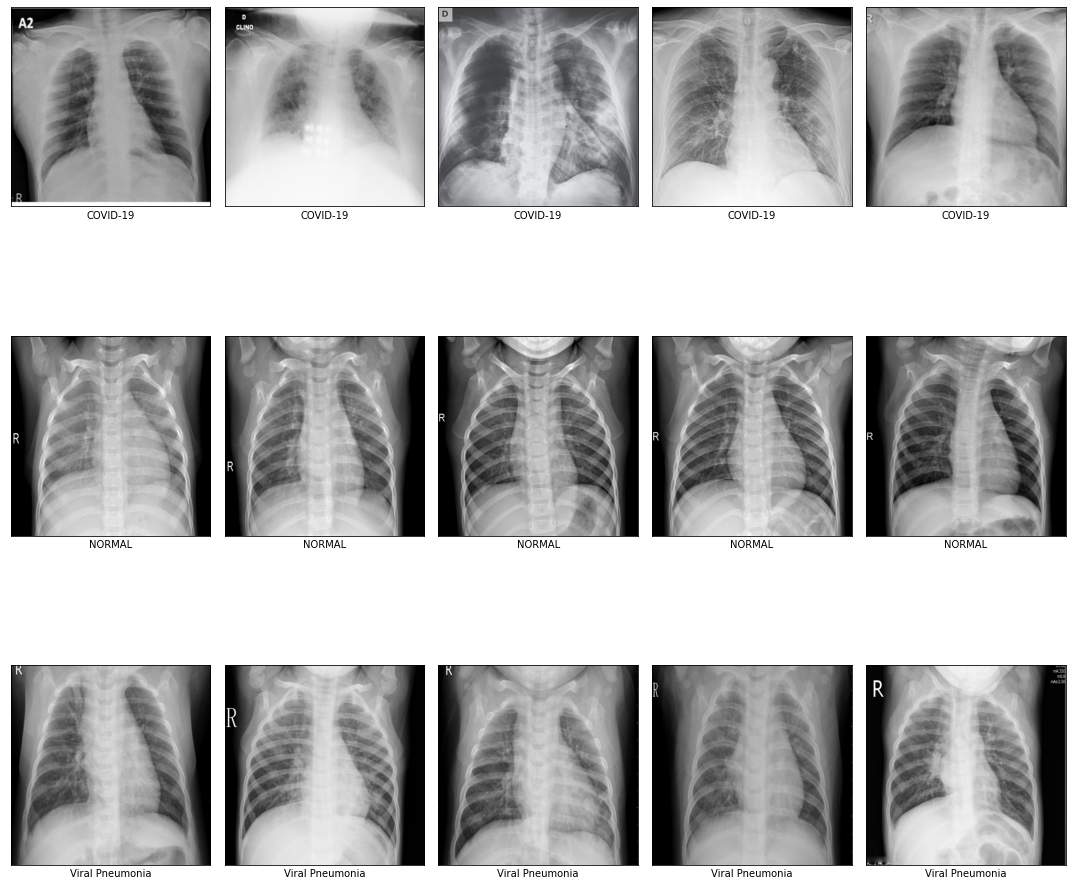

In [5]:
# Randomly view 5 images in each category

fig, axs = plt.subplots(len(labels), 5, figsize = (15, 15))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

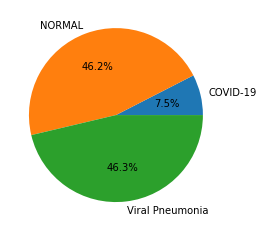

In [6]:
# Make a pie-chart to visualize the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels = class_len.keys(),
    autopct = "%1.1f%%"
)
fig.show()
# The dataset is imbalance so we will have to take care of that later.

# Creating image generators

In [7]:
# We do not have separate folders for training and validation. 
# We need to read training and validation images from the same folder such that:
# 1. There is no data leak i.e. Training images should not appear as validation images.                 
# 2. We must be able to apply augmentation to training images but not validation images.  
# We shall adopt the following strategy:
# 1. Use the same validation_split in ImageDataGenerator for training and validation.
# 2. Use the same seed when using flow_from_directory for training and validation. 
# To veify the correctness of this approach, you can print filenames from each generator and check for overlap.

# Another problem is that along with the 3 image data folders, there are files we are not making use of.
# To be sure that images are read from the correct folders, we can specify the directory and the labels.

# Note that we use simple augmentation to avoid producing unsuitable images.

datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'training'
)

val_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'validation'
)

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [8]:
# To veify the correctness of this approach (empty set is expected)
set(val_generator.filenames).intersection(set(train_generator.filenames))

set()

In [9]:
# Check out labeling
val_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

# Model building

We shall start with InceptionV3 architecture trained on imagenet and fine tune.

In [10]:
basemodel = InceptionV3(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = Input((256, 256, 3)),
)

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
basemodel.trainable = True

In [12]:
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
# Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Flatten()(headmodel) 
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(3, activation = "softmax")(headmodel) # 3 classes

model = Model(inputs = basemodel.input, outputs = headmodel)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# Compile the model

# Given that COVID-19 spreads very quickly, it is important that we identify as many cases as possible.
# We do not care a lot about Flase Positives (precision), because it may be okay to declare normal people as being COVID-19 positive.
# However, we really really care about False Negatives (recall), because it is NOT okay to declare COVID-19 positive people as being normal!

MyList = ["accuracy"]
MyList += [Recall(class_id = i) for i in range(len(labels))] 
MyList += [Precision(class_id = i) for i in range(len(labels))]

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = MyList
)

In [16]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = "recall",
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5", 
    save_best_only = True
)

# Model training

In [17]:
# Previously we found that there was class imbalance. 
# We shall use class weights to tackle this before moving to training.

total_wt = sum(class_len.values())

weights = {
    0: 0.5 * (1 - class_len[labels[0]]/total_wt),
    1: 0.5 * (1 - class_len[labels[1]]/total_wt),
    2: 0.5 * (1 - class_len[labels[2]]/total_wt)
}
weights

{0: 0.46230636833046473, 1: 0.2691910499139415, 2: 0.2685025817555938}

In [18]:
# Finally, fit the neural network model to the data.

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 64,
    epochs = 10
)

Epoch 1/10
64/64 [==============================] - 90s 1s/step - loss: 0.3866 - accuracy: 0.8625 - recall: 0.5350 - recall_1: 0.8652 - recall_2: 0.8497 - precision: 0.8077 - precision_1: 0.8890 - precision_2: 0.8893
Epoch 2/10
64/64 [==============================] - 85s 1s/step - loss: 0.2260 - accuracy: 0.9210 - recall: 0.7973 - recall_1: 0.9395 - recall_2: 0.9000 - precision: 0.8551 - precision_1: 0.9327 - precision_2: 0.9342
Epoch 3/10
64/64 [==============================] - 86s 1s/step - loss: 0.1760 - accuracy: 0.9406 - recall: 0.8217 - recall_1: 0.9501 - recall_2: 0.9392 - precision: 0.8658 - precision_1: 0.9521 - precision_2: 0.9504
Epoch 4/10
64/64 [==============================] - 87s 1s/step - loss: 0.1372 - accuracy: 0.9536 - recall: 0.8693 - recall_1: 0.9630 - recall_2: 0.9547 - precision: 0.9172 - precision_1: 0.9600 - precision_2: 0.9628
Epoch 5/10
64/64 [==============================] - 85s 1s/step - loss: 0.1513 - accuracy: 0.9494 - recall: 0.8994 - recall_1: 0.956

Found 580 images belonging to 3 classes.


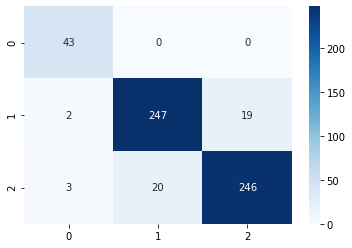

In [19]:
val_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = 42,
    batch_size = 32, 
    shuffle = False,
    subset = 'validation'
)

# Obtain predictions
pred = model.predict_generator(val_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = val_generator.classes
    
# Now plot matrix
cm = confusion_matrix(actual, pred, labels = [0, 1, 2])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()

In [20]:
# Classification Report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        43
           1       0.93      0.92      0.92       268
           2       0.93      0.91      0.92       269

    accuracy                           0.92       580
   macro avg       0.92      0.95      0.93       580
weighted avg       0.92      0.92      0.92       580



In [21]:
tf.saved_model.save(model, 'keras_model/modelo')